Estimating functional connectivity

In [2]:
%matplotlib inline 
import os
import glob
import numpy as np
from numpy.fft import fft, ifft, fftfreq
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.animation import FuncAnimation
import seaborn as sns
import nibabel as nib
from nilearn.plotting import view_img, plot_glass_brain, plot_anat, plot_epi
from nltools.data import Brain_Data, Adjacency
from nltools.mask import expand_mask, roi_to_brain
from nltools.stats import isc, isfc, isps, fdr, threshold, phase_randomize, circle_shift, _butter_bandpass_filter, _phase_mean_angle, _phase_vector_length
from nilearn.plotting import view_img_on_surf, view_img
from sklearn.metrics import pairwise_distances
from sklearn.utils import check_random_state
from scipy.stats import ttest_1samp
from scipy.signal import hilbert
from scipy.stats import pearsonr
from scipy.stats import zscore
import networkx as nx
from IPython.display import HTML
import sys

In [3]:
os.chdir ('/project/3013104.01/analysis/fc')
os.getcwd()

'/project/3013104.01/analysis/fc'

Load ROI parcellation atlas data: http://preprocessed-connectomes-project.org/abide/Pipelines.html OR https://github.com/neurodata/neuroparc/tree/master/atlases/label/Human

/home/posdevpsy/chrgon/.local/lib/python3.8/site-packages/nilearn/maskers/nifti_masker.py:98: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/posdevpsy/chrgon/.local/lib/python3.8/site-packages/nilearn/image/resampling.py:597: UserWarning: Casting data from int16 to float32
  warnings.warn(f"Casting data from {data.dtype.name} to {aux}")


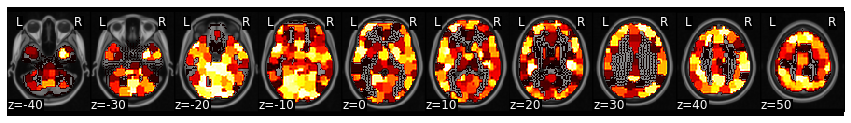

In [22]:
#parcellation_atlas = Brain_Data('/project/3013104.01/analysis/fc/cc200_roi_atlas.nii.gz')
#parcellation_atlas.plot()

/home/posdevpsy/chrgon/.local/lib/python3.8/site-packages/nilearn/masking.py:975: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(mask_img, unmasked, affine)


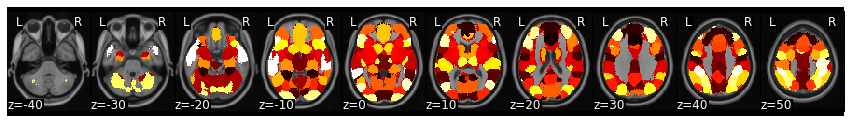

In [2]:
mask = Brain_Data('http://neurovault.org/media/images/2099/Neurosynth%20Parcellation_0.nii.gz')
mask_x = expand_mask(mask)

mask.plot()

Make a subject list and an input image files list

In [4]:
data_dir = '/project/3013104.01/analysis/average_ROI_n50/'
sub_list = [os.path.basename(x).split('_')[0] for x in glob.glob(os.path.join(data_dir, 'subject-*'))]
def remove_duplicates(lst):
    return list(set(lst))
sub_list = remove_duplicates(sub_list)
sub_list.sort()
mri_movietasks = ['mri_movietask_1', 'mri_movietask_2', 'mri_movietask_3']

Create a list of all fMRI data and store in a variable called 'file_list'

In [4]:
data_dir = '/project/3013104.01/pulled-data-MRI/'
# Use glob to find all files matching the pattern
file_list = glob.glob(os.path.join(data_dir, 'subject-*/mri_movietask_*/filtered_func_data_clean_MNI.nii.gz'))
# Iterate over the matched files
for file_path in file_list:
    print(file_path)

/project/3013104.01/pulled-data-MRI/subject-0126/mri_movietask_2/filtered_func_data_clean_MNI.nii.gz
/project/3013104.01/pulled-data-MRI/subject-0126/mri_movietask_3/filtered_func_data_clean_MNI.nii.gz
/project/3013104.01/pulled-data-MRI/subject-0201/mri_movietask_1/filtered_func_data_clean_MNI.nii.gz
/project/3013104.01/pulled-data-MRI/subject-0201/mri_movietask_2/filtered_func_data_clean_MNI.nii.gz
/project/3013104.01/pulled-data-MRI/subject-0201/mri_movietask_3/filtered_func_data_clean_MNI.nii.gz
/project/3013104.01/pulled-data-MRI/subject-0139/mri_movietask_3/filtered_func_data_clean_MNI.nii.gz
/project/3013104.01/pulled-data-MRI/subject-0139/mri_movietask_1/filtered_func_data_clean_MNI.nii.gz
/project/3013104.01/pulled-data-MRI/subject-0139/mri_movietask_2/filtered_func_data_clean_MNI.nii.gz
/project/3013104.01/pulled-data-MRI/subject-0186/mri_movietask_1/filtered_func_data_clean_MNI.nii.gz
/project/3013104.01/pulled-data-MRI/subject-0186/mri_movietask_2/filtered_func_data_clean_M

Similar to Vanderwal et al., 2015, but with the neurosynth 50-ROI atlas. Already have the combined 3-session mean time series estimation from the previous ISC analysis, so will use that data to run a functional connectivity analysis between the 50 ROIs.

extracted mean time series of each ROI

In [5]:
data_dir = '/project/3013104.01/analysis/average_ROI_n50/appended_sessions'
# Use glob to find all files matching the pattern
file_list = glob.glob(os.path.join(data_dir, '*'))
# Iterate over the matched files
for file_path in file_list:
    print(file_path)

/project/3013104.01/analysis/average_ROI_n50/appended_sessions/subject-0001_all_sessions.csv
/project/3013104.01/analysis/average_ROI_n50/appended_sessions/subject-0002_all_sessions.csv
/project/3013104.01/analysis/average_ROI_n50/appended_sessions/subject-0003_all_sessions.csv
/project/3013104.01/analysis/average_ROI_n50/appended_sessions/subject-0004_all_sessions.csv
/project/3013104.01/analysis/average_ROI_n50/appended_sessions/subject-0005_all_sessions.csv
/project/3013104.01/analysis/average_ROI_n50/appended_sessions/subject-0006_all_sessions.csv
/project/3013104.01/analysis/average_ROI_n50/appended_sessions/subject-0007_all_sessions.csv
/project/3013104.01/analysis/average_ROI_n50/appended_sessions/subject-0008_all_sessions.csv
/project/3013104.01/analysis/average_ROI_n50/appended_sessions/subject-0009_all_sessions.csv
/project/3013104.01/analysis/average_ROI_n50/appended_sessions/subject-0010_all_sessions.csv
/project/3013104.01/analysis/average_ROI_n50/appended_sessions/subject

compute Pearson's correlation between all ROI pairs to produce a 50×50 whole-brain connectivity matrix for each subject

In [40]:
os.chdir ('/project/3013104.01/analysis/average_ROI_n50/')
os.getcwd()

import os
import pandas as pd

# Input and output directories
input_directory = 'appended_sessions' 
output_directory = 'appended_sessions/fc'

# Create the output directory if it doesn't exist
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Iterate over CSV files in the input directory
for filename in os.listdir(input_directory):
    if filename.endswith('.csv'):
        # Read the CSV file
        filepath = os.path.join(input_directory, filename)
        df = pd.read_csv(filepath)

        # Compute correlation between rows and columns
        corr_matrix = df.corr()

        # Generate the output filepath
        output_filename = os.path.splitext(filename)[0] + '_connectivity.csv'
        output_filepath = os.path.join(output_directory, output_filename)

        # Export the correlation matrix to a new CSV file
        corr_matrix.to_csv(output_filepath, index=True)

In [ ]:
import glob
import shutil

# Get a list of all files matching the pattern "*connectivity.csv"
files_to_move = glob.glob('*connectivity.csv')

# Move each file to the "fc/" directory
for file in files_to_move:
    shutil.move(file, 'fc/')

In [41]:
os.chdir('/project/3013104.01/analysis/fc/z-transformed')
os.getcwd()

'/project/3013104.01/analysis/fc/z-transformed'

Transform to z-scores; standardized by mean and standard deviation of input array a

In [42]:
data_dir = '/project/3013104.01/analysis/fc'
os.chdir('/project/3013104.01/analysis/fc/z-transformed')
for sub in sub_list:
    sub_data = pd.read_csv(os.path.join(data_dir, f'{sub}_all_sessions_connectivity.csv'))
    sub_data.apply(zscore)
    output_file = f"{sub}_connectivity_z.csv"
    pd.DataFrame(sub_data).to_csv(output_file, index=False)
    print(f"Z-transformed correlations saved for {sub} as {output_file}.")

Z-transformed correlations saved for subject-0001 as subject-0001_connectivity_z.csv.
Z-transformed correlations saved for subject-0002 as subject-0002_connectivity_z.csv.
Z-transformed correlations saved for subject-0003 as subject-0003_connectivity_z.csv.
Z-transformed correlations saved for subject-0004 as subject-0004_connectivity_z.csv.
Z-transformed correlations saved for subject-0005 as subject-0005_connectivity_z.csv.
Z-transformed correlations saved for subject-0006 as subject-0006_connectivity_z.csv.
Z-transformed correlations saved for subject-0007 as subject-0007_connectivity_z.csv.
Z-transformed correlations saved for subject-0008 as subject-0008_connectivity_z.csv.
Z-transformed correlations saved for subject-0009 as subject-0009_connectivity_z.csv.
Z-transformed correlations saved for subject-0010 as subject-0010_connectivity_z.csv.
Z-transformed correlations saved for subject-0011 as subject-0011_connectivity_z.csv.
Z-transformed correlations saved for subject-0012 as s

Z-transformed correlations saved for subject-0099 as subject-0099_connectivity_z.csv.
Z-transformed correlations saved for subject-0100 as subject-0100_connectivity_z.csv.
Z-transformed correlations saved for subject-0101 as subject-0101_connectivity_z.csv.
Z-transformed correlations saved for subject-0102 as subject-0102_connectivity_z.csv.
Z-transformed correlations saved for subject-0103 as subject-0103_connectivity_z.csv.
Z-transformed correlations saved for subject-0104 as subject-0104_connectivity_z.csv.
Z-transformed correlations saved for subject-0105 as subject-0105_connectivity_z.csv.
Z-transformed correlations saved for subject-0106 as subject-0106_connectivity_z.csv.
Z-transformed correlations saved for subject-0107 as subject-0107_connectivity_z.csv.
Z-transformed correlations saved for subject-0108 as subject-0108_connectivity_z.csv.
Z-transformed correlations saved for subject-0109 as subject-0109_connectivity_z.csv.
Z-transformed correlations saved for subject-0110 as s

Z-transformed correlations saved for subject-0196 as subject-0196_connectivity_z.csv.
Z-transformed correlations saved for subject-0197 as subject-0197_connectivity_z.csv.
Z-transformed correlations saved for subject-0198 as subject-0198_connectivity_z.csv.
Z-transformed correlations saved for subject-0199 as subject-0199_connectivity_z.csv.
Z-transformed correlations saved for subject-0200 as subject-0200_connectivity_z.csv.
Z-transformed correlations saved for subject-0201 as subject-0201_connectivity_z.csv.
Z-transformed correlations saved for subject-0202 as subject-0202_connectivity_z.csv.
Z-transformed correlations saved for subject-0203 as subject-0203_connectivity_z.csv.
Z-transformed correlations saved for subject-0204 as subject-0204_connectivity_z.csv.
Z-transformed correlations saved for subject-0205 as subject-0205_connectivity_z.csv.
Z-transformed correlations saved for subject-0206 as subject-0206_connectivity_z.csv.
Z-transformed correlations saved for subject-0207 as s

Extract and vectorize the upper triangle of z-score matrices

In [43]:
import os
import pandas as pd
import numpy as np
os.chdir('/project/3013104.01/analysis')

# Step 1: Specify the directory containing CSV files
directory = 'fc/z-transformed/'

# Step 2: Loop over each file in the directory
for filename in os.listdir(directory):
    if filename.endswith('.csv'):
        # Step 3: Import the correlation matrix from the CSV file
        file_path = os.path.join(directory, filename)
        correlation_df = pd.read_csv(file_path)

        # Step 4: Extract and vectorize the upper triangle of the DataFrame
        upper_triangle = correlation_df.where(np.triu(np.ones(correlation_df.shape), k=1).astype(bool))

        # Step 5: Label rows to indicate the row and header pair
        rows, cols = np.where(upper_triangle.notna())
        labels = [f"{correlation_df.index[i]}_{correlation_df.columns[j]}" for i, j in zip(rows, cols)]

        # Step 6: Create a new DataFrame with labeled rows
        labeled_df = pd.DataFrame({'Label': labels, 'Correlation': upper_triangle.stack().values})

        # Step 7: Output the DataFrame into an output directory
        output_directory = 'fc/z-transformed/vectorized_upper_triangles/'
        output_filename = os.path.splitext(filename)[0] + '_vectorized.csv'
        output_path = os.path.join(output_directory, output_filename)
        labeled_df.to_csv(output_path, index=False)

        print(f"Output saved to: {output_path}")


Output saved to: fc/z-transformed/vectorized_upper_triangles/subject-0035_connectivity_z_vectorized.csv
Output saved to: fc/z-transformed/vectorized_upper_triangles/subject-0038_connectivity_z_vectorized.csv
Output saved to: fc/z-transformed/vectorized_upper_triangles/subject-0046_connectivity_z_vectorized.csv
Output saved to: fc/z-transformed/vectorized_upper_triangles/subject-0050_connectivity_z_vectorized.csv
Output saved to: fc/z-transformed/vectorized_upper_triangles/subject-0054_connectivity_z_vectorized.csv
Output saved to: fc/z-transformed/vectorized_upper_triangles/subject-0058_connectivity_z_vectorized.csv
Output saved to: fc/z-transformed/vectorized_upper_triangles/subject-0062_connectivity_z_vectorized.csv
Output saved to: fc/z-transformed/vectorized_upper_triangles/subject-0066_connectivity_z_vectorized.csv
Output saved to: fc/z-transformed/vectorized_upper_triangles/subject-0070_connectivity_z_vectorized.csv
Output saved to: fc/z-transformed/vectorized_upper_triangles/sub

Output saved to: fc/z-transformed/vectorized_upper_triangles/subject-0145_connectivity_z_vectorized.csv
Output saved to: fc/z-transformed/vectorized_upper_triangles/subject-0084_connectivity_z_vectorized.csv
Output saved to: fc/z-transformed/vectorized_upper_triangles/subject-0086_connectivity_z_vectorized.csv
Output saved to: fc/z-transformed/vectorized_upper_triangles/subject-0087_connectivity_z_vectorized.csv
Output saved to: fc/z-transformed/vectorized_upper_triangles/subject-0088_connectivity_z_vectorized.csv
Output saved to: fc/z-transformed/vectorized_upper_triangles/subject-0090_connectivity_z_vectorized.csv
Output saved to: fc/z-transformed/vectorized_upper_triangles/subject-0091_connectivity_z_vectorized.csv
Output saved to: fc/z-transformed/vectorized_upper_triangles/subject-0092_connectivity_z_vectorized.csv
Output saved to: fc/z-transformed/vectorized_upper_triangles/subject-0094_connectivity_z_vectorized.csv
Output saved to: fc/z-transformed/vectorized_upper_triangles/sub

Output saved to: fc/z-transformed/vectorized_upper_triangles/subject-0183_connectivity_z_vectorized.csv
Output saved to: fc/z-transformed/vectorized_upper_triangles/subject-0184_connectivity_z_vectorized.csv
Output saved to: fc/z-transformed/vectorized_upper_triangles/subject-0191_connectivity_z_vectorized.csv
Output saved to: fc/z-transformed/vectorized_upper_triangles/subject-0185_connectivity_z_vectorized.csv
Output saved to: fc/z-transformed/vectorized_upper_triangles/subject-0186_connectivity_z_vectorized.csv
Output saved to: fc/z-transformed/vectorized_upper_triangles/subject-0188_connectivity_z_vectorized.csv
Output saved to: fc/z-transformed/vectorized_upper_triangles/subject-0189_connectivity_z_vectorized.csv
Output saved to: fc/z-transformed/vectorized_upper_triangles/subject-0190_connectivity_z_vectorized.csv
Output saved to: fc/z-transformed/vectorized_upper_triangles/subject-0192_connectivity_z_vectorized.csv
Output saved to: fc/z-transformed/vectorized_upper_triangles/sub

Transpose all of the csv files and insert subject numbers

In [44]:
import os
import csv

input_directory = "fc/z-transformed/vectorized_upper_triangles/"
output_directory = "fc/z-transformed/vectorized_upper_triangles/transposed/"

# Create output directory if it doesn't exist
os.makedirs(output_directory, exist_ok=True)

# Get a list of files in the input directory
input_files = os.listdir(input_directory)

for input_filename in input_files:
    if input_filename.endswith(".csv"):
        # Get the subject number from the filename
        file_basename = os.path.basename(input_filename)
        matching_part = file_basename.split('_')[0]

        # Check if the subject number starts with "subject-0***"
        if matching_part.startswith("subject-0"):
            # Construct full file paths
            input_filepath = os.path.join(input_directory, input_filename)
            output_filename = f"{matching_part}_transposed.csv"
            output_filepath = os.path.join(output_directory, output_filename)

            # Read CSV file
            with open(input_filepath, 'r') as file:
                reader = csv.reader(file)
                data = list(reader)

            # Transpose the data
            transposed_data = list(map(list, zip(*data)))

            # Replace the row name of the second row with subject number
            transposed_data[1][0] = matching_part
            transposed_data[0][0] = 'roi_roi'

            # Export modified data as a CSV file
            with open(output_filepath, 'w', newline='') as file:
                writer = csv.writer(file)
                writer.writerows(transposed_data)

            print(f"Modified CSV file exported as: {output_filepath}")
        else:
            print(f"Skipping file '{input_filename}' as it does not match the required pattern.")


Modified CSV file exported as: fc/z-transformed/vectorized_upper_triangles/transposed/subject-0035_transposed.csv
Modified CSV file exported as: fc/z-transformed/vectorized_upper_triangles/transposed/subject-0038_transposed.csv
Modified CSV file exported as: fc/z-transformed/vectorized_upper_triangles/transposed/subject-0046_transposed.csv
Modified CSV file exported as: fc/z-transformed/vectorized_upper_triangles/transposed/subject-0050_transposed.csv
Modified CSV file exported as: fc/z-transformed/vectorized_upper_triangles/transposed/subject-0054_transposed.csv
Modified CSV file exported as: fc/z-transformed/vectorized_upper_triangles/transposed/subject-0058_transposed.csv
Modified CSV file exported as: fc/z-transformed/vectorized_upper_triangles/transposed/subject-0062_transposed.csv
Modified CSV file exported as: fc/z-transformed/vectorized_upper_triangles/transposed/subject-0066_transposed.csv
Modified CSV file exported as: fc/z-transformed/vectorized_upper_triangles/transposed/su

Modified CSV file exported as: fc/z-transformed/vectorized_upper_triangles/transposed/subject-0060_transposed.csv
Modified CSV file exported as: fc/z-transformed/vectorized_upper_triangles/transposed/subject-0061_transposed.csv
Modified CSV file exported as: fc/z-transformed/vectorized_upper_triangles/transposed/subject-0063_transposed.csv
Modified CSV file exported as: fc/z-transformed/vectorized_upper_triangles/transposed/subject-0064_transposed.csv
Modified CSV file exported as: fc/z-transformed/vectorized_upper_triangles/transposed/subject-0065_transposed.csv
Modified CSV file exported as: fc/z-transformed/vectorized_upper_triangles/transposed/subject-0067_transposed.csv
Modified CSV file exported as: fc/z-transformed/vectorized_upper_triangles/transposed/subject-0068_transposed.csv
Modified CSV file exported as: fc/z-transformed/vectorized_upper_triangles/transposed/subject-0069_transposed.csv
Modified CSV file exported as: fc/z-transformed/vectorized_upper_triangles/transposed/su

Modified CSV file exported as: fc/z-transformed/vectorized_upper_triangles/transposed/subject-0160_transposed.csv
Modified CSV file exported as: fc/z-transformed/vectorized_upper_triangles/transposed/subject-0161_transposed.csv
Modified CSV file exported as: fc/z-transformed/vectorized_upper_triangles/transposed/subject-0162_transposed.csv
Modified CSV file exported as: fc/z-transformed/vectorized_upper_triangles/transposed/subject-0163_transposed.csv
Modified CSV file exported as: fc/z-transformed/vectorized_upper_triangles/transposed/subject-0164_transposed.csv
Modified CSV file exported as: fc/z-transformed/vectorized_upper_triangles/transposed/subject-0165_transposed.csv
Modified CSV file exported as: fc/z-transformed/vectorized_upper_triangles/transposed/subject-0166_transposed.csv
Modified CSV file exported as: fc/z-transformed/vectorized_upper_triangles/transposed/subject-0167_transposed.csv
Modified CSV file exported as: fc/z-transformed/vectorized_upper_triangles/transposed/su

Modified CSV file exported as: fc/z-transformed/vectorized_upper_triangles/transposed/subject-0239_transposed.csv
Modified CSV file exported as: fc/z-transformed/vectorized_upper_triangles/transposed/subject-0017_transposed.csv
Modified CSV file exported as: fc/z-transformed/vectorized_upper_triangles/transposed/subject-0018_transposed.csv
Modified CSV file exported as: fc/z-transformed/vectorized_upper_triangles/transposed/subject-0019_transposed.csv
Modified CSV file exported as: fc/z-transformed/vectorized_upper_triangles/transposed/subject-0020_transposed.csv
Modified CSV file exported as: fc/z-transformed/vectorized_upper_triangles/transposed/subject-0021_transposed.csv
Modified CSV file exported as: fc/z-transformed/vectorized_upper_triangles/transposed/subject-0022_transposed.csv
Modified CSV file exported as: fc/z-transformed/vectorized_upper_triangles/transposed/subject-0023_transposed.csv
Modified CSV file exported as: fc/z-transformed/vectorized_upper_triangles/transposed/su

Concatenate ROI-ROI correlations across subjects

In [48]:
import pandas as pd
import os
os.chdir('/project/3013104.01/analysis')

# Set the directory path where the CSV files are located
directory = "fc/z-transformed/vectorized_upper_triangles/transposed/"

# Get a list of all CSV files in the directory
csv_files = [file for file in os.listdir(directory) if file.endswith('.csv')]

# Initialize an empty DataFrame to store the concatenated data
concatenated_df = pd.DataFrame()

# Concatenate all CSV files
for file in csv_files:
    file_path = os.path.join(directory, file)
    df = pd.read_csv(file_path)
    concatenated_df = pd.concat([concatenated_df, df])

# Change the name of the first column to "subject"
concatenated_df.rename(columns={concatenated_df.columns[0]: 'subject'}, inplace=True)

# Output the concatenated DataFrame as a CSV file
output_file = 'FC_all.csv'
concatenated_df.to_csv(output_file, index=False)

print('Concatenation complete. Output saved as FC_all.csv')

Concatenation complete. Output saved as FC_all.csv


Merge FC_all with SPSQ-24 data

In [50]:
# Merge data containing SPS scores, whole-brain ISC, and ROI-specific ISC

os.chdir ('/project/3013104.01/analysis')

# Read the CSV files
df1 = pd.read_csv('FC_all.csv')
df2 = pd.read_csv('ISC_SPSQ_merged_standardized.csv')

# Merge the files based on a common column
merged_df = pd.merge(df1, df2, on='subject')

# Save the merged data to a new CSV file
merged_df.to_csv('FC_ISC_SPSQ_merged_standardized.csv', index=False)

Calculate the association between SPSQ-24 score and the correlation between each pair of ROIs

qualitatively assess similarities across conditions in terms of the correlations within and between large-scale functional networks; arrange the ROIs on the matrix according to network membership using a 7-network scheme (visual, somatomotor, dorsal attention, ventral attention, limbic, frontoparietal, and default mode networks).